In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/ML2_Project/AML_Data_val.zip'
extract_path = '/content/Data2'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

def count_folders_in_directory(directory):
    return sum(os.path.isdir(os.path.join(directory, i)) for i in os.listdir(directory))

directory_path = '/content/Data2/Data_val/train/Finger flicking'
folder_count = count_folders_in_directory(directory_path)

print(f"Number of folders in '{directory_path}': {folder_count}")


Number of folders in '/content/Data2/Data_val/train/Finger flicking': 1075


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from PIL import Image
import copy

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = {'Arm flapping': 0, 'Finger flicking': 1, 'Null': 2}
        self.bunches, self.labels = self._load_bunches()

    def _load_bunches(self):
        bunches, labels = [], []
        for class_name, class_idx in self.classes.items():
            class_dir = os.path.join(self.root_dir, class_name)
            for bunch in os.listdir(class_dir):
                bunch_dir = os.path.join(class_dir, bunch)
                if os.path.isdir(bunch_dir):
                    frames = sorted([os.path.join(bunch_dir, f) for f in os.listdir(bunch_dir) if f.endswith('.jpg')])
                    if len(frames) == 15:
                        bunches.append(frames)  # Each bunch is a list of frame file paths
                        labels.append(class_idx)
        return bunches, labels

    def __len__(self):
        return len(self.bunches)

    def __getitem__(self, idx):
        # Load frames for the video (bunch)
        frames = [Image.open(frame) for frame in self.bunches[idx]]

        # Apply transformation to each frame
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        # Stack frames along a new dimension (sequence_length) to create a 4D tensor
        video_tensor = torch.stack(frames)

        label = self.labels[idx]
        return video_tensor, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = VideoDataset(root_dir='/content/Data2/Data_val/train', transform=transform)
val_dataset = VideoDataset(root_dir='/content/Data2/Data_val/val', transform=transform)
test_dataset = VideoDataset(root_dir='/content/Data2/Data_val/test', transform=transform)

In [ ]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define the fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Get the batch size and sequence length
        batch_size, sequence_length, feature_map_size, height, width = x.size()

        # Reshape the input tensor to have 3 dimensions
        x = x.view(batch_size, sequence_length, -1)  # Shape: (batch_size, sequence_length, feature_map_size * height * width)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))  # Shape: (batch_size, sequence_length, hidden_size)

        # Get the output from the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Pass the output through the fully connected layer for classification
        out = self.fc(out)  # Shape: (batch_size, num_classes)

        return out


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        total_loss, total_correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / total)
        train_accuracies.append(total_correct / total)

        # Validation
        model.eval()
        with torch.no_grad():
            total_loss, total_correct, total = 0, 0, 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total += labels.size(0)

            val_losses.append(total_loss / total)
            val_accuracy = total_correct / total
            val_accuracies.append(val_accuracy)

            # Save the model if validation accuracy improves
            if val_accuracy > best_acc:
                best_acc = val_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, '
              f'Train Acc: {train_accuracies[-1]:.4f}, '
              f'Val Acc: {val_accuracies[-1]:.4f}')
        print()

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
sample_batch, _ = next(iter(train_loader))
sample_frame = sample_batch[0][0]  # Take the first video in the batch and the first frame of that video
feature_map_size = sample_frame.shape[0]  # Get the number of channels in the frame
print("Feature Map Size:", feature_map_size)

Feature Map Size: 3


In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the RNN model
num_layers = 3
rnn_model = RNNModel(input_size=224*224*3 , hidden_size=256, num_layers=num_layers, num_classes=3).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the RNN model using the train_model function
epochs= 30
rnn_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(rnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=epochs)


In [ ]:
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

Accuracy on the test set: 47.62%


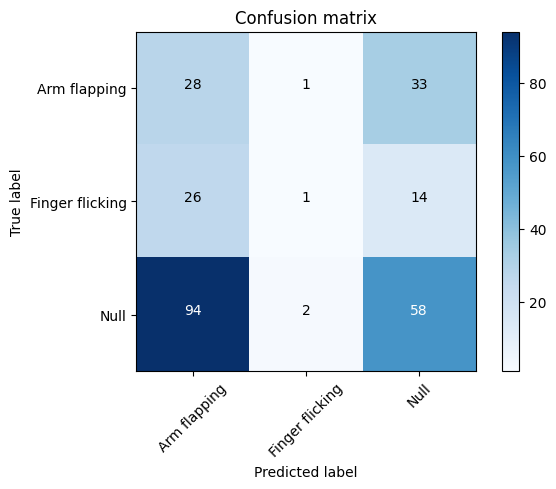

Model training and evaluation complete.


In [ ]:
model = rnn_model
model.eval()
correct = 0
total = 0
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
#print(f"Accuracy on the test set: {test_accuracy:.2f}%")

# Assuming you have the `plot_confusion_matrix` function defined
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['Arm flapping', 'Finger flicking', 'Null'])

print('Model training and evaluation complete.')


In [ ]:
import numpy as np

def calculate_precision(confusion_matrix):
    precision = np.zeros(confusion_matrix.shape[0])
    for i in range(confusion_matrix.shape[0]):
        if np.sum(confusion_matrix, axis=0)[i] != 0:
            precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix, axis=0)[i]
        else:
            precision[i] = 0.0
    return precision




def calculate_metrics(confusion_matrix):
    precision = calculate_precision(confusion_matrix)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)  # Convert NaNs to zeros

    # Calculate metrics for each class
    metrics = {}
    for i in range(len(confusion_matrix)):
        metrics[f'Class {i}'] = {
            'Precision': precision[i],
            'Recall/Sensitivity': recall[i],
            'F1-Score': f1_scores[i]
        }

    # Calculate overall averages (macro average, not weighted)
    avg_precision = np.nanmean(precision)
    avg_recall = np.nanmean(recall)
    avg_f1_score = np.nanmean(f1_scores)

    metrics['Average'] = {
        'Precision': avg_precision,
        'Recall/Sensitivity': avg_recall,
        'F1-Score': avg_f1_score
    }

    return metrics

# Example usage
confusion_matrix = np.array([[29, 2, 31], [21, 1, 19], [104, 5, 45]])  # Replace with your confusion matrix
metrics = calculate_metrics(confusion_matrix)
for key, value in metrics.items():
    print(f"{key}: {value}")
